In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

2024-02-29 15:16:00.570108: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 15:16:00.613673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 15:16:00.613699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 15:16:00.614699: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 15:16:00.622376: I tensorflow/core/platform/cpu_feature_guar

## Loading the data

In [3]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
prdlabel = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
prdlabel = prdtype.loc[prdlabel['prdtypecode'], 'prdtypedesignation']
prdlabel = prdlabel.reset_index()

In [4]:
data.head()

,designation,description,productid,imageid,language,designation_translated,description_translated
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de,Olivia : Carnet personnalisé / 150 pages / gri...,NaN
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,en,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN
4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,278535884,1077757786,fr,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...


## Identify duplicates with different product type code

In [3]:
#identify duplicates with same designation and description but different product type code
data_duplicated = data.join(prdlabel.reset_index())
data_duplicated['description'] = data_duplicated['description'].fillna('')
data_duplicated = data_duplicated[data_duplicated.duplicated(['designation', 'description'], keep=False)]
data_duplicated = data_duplicated.groupby(['description', 'designation']).filter(lambda x: x['prdtypecode'].nunique() > 1)
idx_duplicates = data_duplicated.index

In [ ]:
#Remove those duplicates
data = data.drop(index=idx_duplicates)
prdlabel = prdlabel.drop(index=idx_duplicates)

## Tokenize translated text

In [5]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
merged_txt = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)
data['tokens'] = merged_txt.str.lower().apply(lambda x: word_tokenize(x, language='french'))

## Remove stopwords and punctuation from tokens

In [6]:
def remove_wordsubset(words, wordsubset):
    #remove words in wordsubset
    words_filtered = [word for word in words if word not in wordsubset]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [ ]:
#Removing stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, stop_words))

In [26]:
#Removing puntuation
punctuations = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, punctuations))

In [109]:
#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

In [7]:
#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Further cleaning with Regex?

In [ ]:
#import re

#remove words shorter than 4 characters
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b\w{1,2}\b(?!°)", ' ', x))

#remove numbers
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"[0-9]+", ' ', x))

#remove any word that has no vowel
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?![^aeiouyáéíóúàèìòùâêîôûäëïöü])[^\s]+\b", ' ', x))

#removing extra spaces
#data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x.split()))

## Function to plot results

In [8]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Creating train and test sets

In [9]:
from sklearn.model_selection import train_test_split

target = prdlabel['prdtypedesignation']
#Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], target, test_size=0.2, random_state=123, stratify=target)

In [12]:
target.head()

0       Livres occasion
1    Magazines occasion
2    Accessoires gaming
3        Jouets enfants
4          Livres neufs
Name: prdtypedesignation, dtype: object

## Label encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

target = prdlabel['prdtypedesignation']

#Encoding classes as integers
encoder = LabelEncoder()
y_class = encoder.fit_transform(target)

## BERT Tokenization (camembert-base)

In [47]:
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer, CamembertTokenizerFast

num_class = len(np.unique(y_class))
model_name = "camembert-base" #"flaubert/flaubert_base_uncased" #
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_bert = TFAutoModel.from_pretrained(model_name)#, from_pt=True)
# model_bert = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_class)

# for layer in model_bert.layers:
#     layer.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [48]:
n_samples = len(y_class)
max_length = 256 #512 #

y_class = y_class[:n_samples]
X = list(data['tokens'].iloc[:n_samples])
X = tokenizer(X, padding="max_length", truncation=True, max_length=max_length, return_tensors="tf")
X['input_ids'].shape

TensorShape([84916, 256])

In [69]:
tokenizer.convert_ids_to_tokens(X['input_ids'][1])

['<s>',
 '▁journal',
 '▁des',
 '▁arts',
 '▁(',
 '▁le',
 '▁)',
 '▁n',
 '°',
 '▁13',
 '3',
 '▁du',
 '▁28',
 '/09/',
 '2001',
 '▁-',
 '▁l',
 "'",
 'art',
 '▁et',
 '▁son',
 '▁marche',
 '▁salon',
 '▁d',
 "'",
 'art',
 '▁asiatique',
 '▁a',
 '▁paris',
 '▁-',
 '▁j',
 'ac',
 'ques',
 '▁barre',
 're',
 '▁-',
 '▁franco',
 'is',
 '▁per',
 'rier',
 '▁-',
 '▁la',
 '▁re',
 'forme',
 '▁des',
 '▁ventes',
 '▁aux',
 '▁en',
 'cher',
 'es',
 '▁publiques',
 '▁-',
 '▁le',
 '▁s',
 'na',
 '▁fete',
 '▁ses',
 '▁cent',
 '▁ans',
 '▁',
 '.',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<

In [49]:
from sklearn.model_selection import train_test_split

X_ids = X['input_ids'].numpy()
attention_masks = X['attention_mask'].numpy()
X_train, X_test, y_train, y_test, attention_masks_train, attention_masks_test = train_test_split(X_ids, y_class, attention_masks, test_size=0.2, random_state=123, stratify=y_class)

train_data = tf.data.Dataset.from_tensor_slices(((X_train, attention_masks_train), y_train))
test_data = tf.data.Dataset.from_tensor_slices(((X_test, attention_masks_test), y_test))

batch_size = 32
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [50]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_length,), dtype='int32', name='attention_mask')

transformer_layer = model_bert([input_ids, attention_mask])

x = transformer_layer[0][:, 0, :]

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(num_class, activation='softmax')(x)

# Construct the final model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

lr = 2e-5
lr_schedule = ExponentialDecay(initial_learning_rate=lr, decay_steps=2000, decay_rate=0.8)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_camembert_model_3 (TFCa  TFBaseModelOutputWithPooli   1106219   ['input_ids[0][0]',           
 membertModel)               ngAndCrossAttentions(last_   52         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                     

In [181]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [29]:
import tensorflow as tf
len(tf.config.experimental.list_physical_devices('GPU'))


2

In [62]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [63]:
#max_length = 256 with batch_size=32 seems to be the limit memory wise. Could try 512 and 16 if sequence length needs to be increased
# history = model.fit([X_train, attention_masks_train], y_train, epochs=5, batch_size=32, validation_data=([X_test, attention_masks_test], y_test)) #class_weight
history = model.fit(train_data, epochs=10, validation_data=test_data, class_weight=class_weights)


Epoch 1/10
2123/2123 [==============================] - 1556s 711ms/step - loss: 1.2335 - accuracy: 0.7117 - val_loss: 0.6121 - val_accuracy: 0.8255
Epoch 2/10
2123/2123 [==============================] - 1510s 711ms/step - loss: 0.5754 - accuracy: 0.8385 - val_loss: 0.5133 - val_accuracy: 0.8466
Epoch 3/10
2123/2123 [==============================] - 1510s 711ms/step - loss: 0.4242 - accuracy: 0.8745 - val_loss: 0.4781 - val_accuracy: 0.8586
Epoch 4/10
2123/2123 [==============================] - 1514s 713ms/step - loss: 0.3271 - accuracy: 0.8996 - val_loss: 0.4635 - val_accuracy: 0.8692
Epoch 5/10
2123/2123 [==============================] - 1518s 715ms/step - loss: 0.2591 - accuracy: 0.9194 - val_loss: 0.4734 - val_accuracy: 0.8715
Epoch 6/10
1798/2123 [========================>.....] - ETA: 3:30 - loss: 0.2134 - accuracy: 0.9323

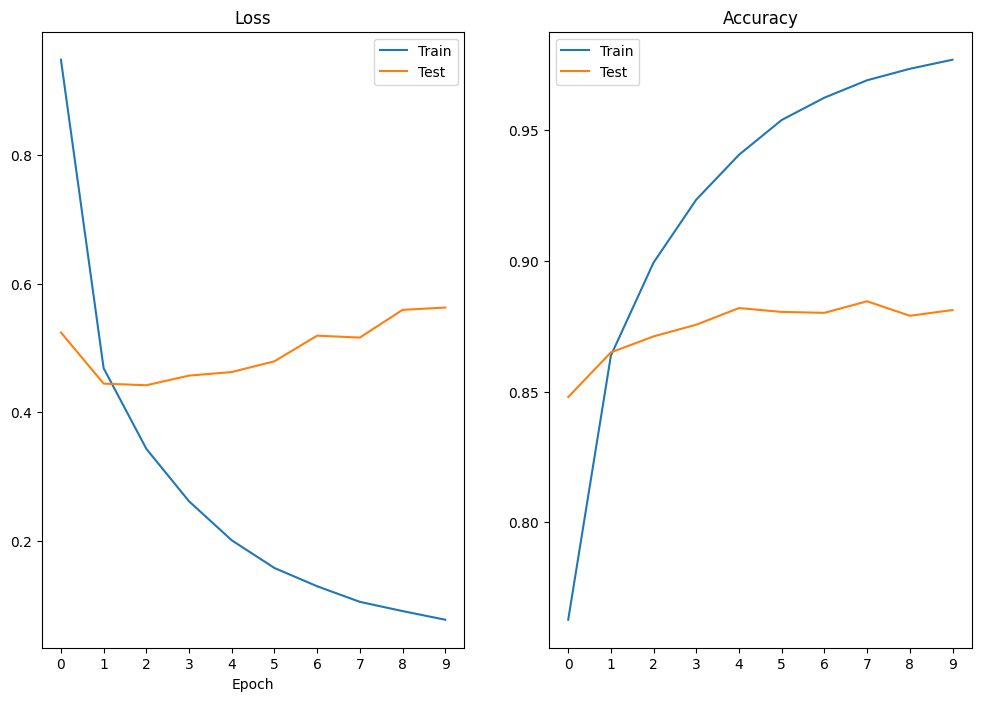

In [44]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Test')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(history.epoch)
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Test')
axs[1].set_xticks(history.epoch)
axs[1].legend()
axs[1].set_title('Accuracy')

plt.show()

531/531 [==============================] - 262s 487ms/step
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       336
           1       0.90      0.91      0.91       165
           2       0.96      0.97      0.96       791
           3       0.95      0.96      0.95       161
           4       0.97      0.88      0.92       166
           5       0.62      0.72      0.67       153
           6       0.86      0.77      0.81       534
           7       0.97      0.93      0.95       998
           8       0.77      0.70      0.73       414
           9       0.99      0.98      0.99      1009
          10       0.79      0.81      0.80       502
          11       0.85      0.82      0.83       284
          12       1.00      0.99      1.00       174
          13       0.77      0.80      0.78       974
          14       0.95      0.91      0.93       861
          15       0.84      0.86      0.85       955
          16       0.7

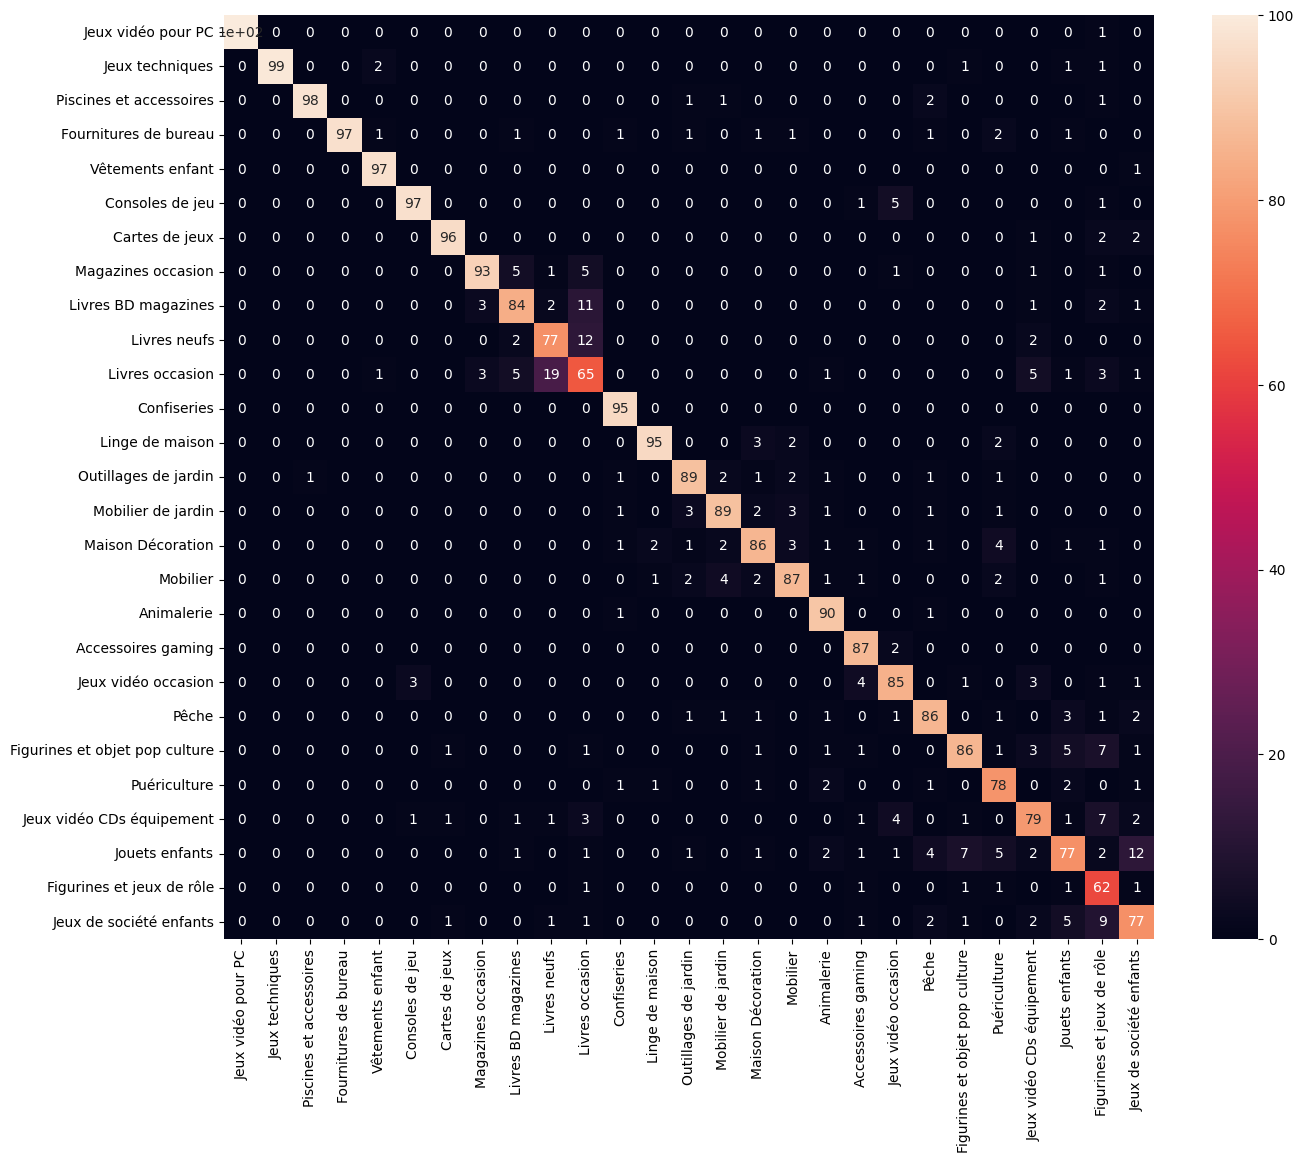

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [45]:
test_pred = model.predict([X_test, attention_masks_test])
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(y_test, test_pred_class, index=encoder.classes_)

In [46]:
from sklearn.metrics import f1_score

f1_score(y_test, test_pred_class, average='weighted')

0.8812683932028269

## Inspect prediction errors

In [150]:
bad = data.loc[X_test.index[test_pred_class != y_test_class]].reset_index()
bad_pred = pd.DataFrame({'predicted': encoder.inverse_transform(test_pred_class[test_pred_class != y_test_class])})
bad_true = pd.DataFrame({'real': encoder.inverse_transform(y_test_class[test_pred_class != y_test_class])})
bad = pd.concat([bad, bad_pred, bad_true], axis=1)
bad = bad[['designation', 'description', 'tokens', 'predicted', 'real']]